# Useful links

- [Choosing colourmaps for plotting gridded data](https://matplotlib.org/stable/users/explain/colors/colormaps.html)
- [List of named colours for plotting time series](https://matplotlib.org/stable/gallery/color/named_colors.html)

# Import required packages

In [6]:
import xarray as xr                                                  # handles gridded data
import numpy as np                                                   # numerical functions etc
import pandas as pd                                                  # handles tables of data (.csv, spreadsheets etc)
import re                                                            # allows manipulation of text strings

import matplotlib                                                    # plotting functions generally
import matplotlib.pyplot as plt                                      # specific plotting function we'll use a lot, so we'll give it a shorter name
from matplotlib.patches import Rectangle                             # specific plotting function with an annoyingly long name

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import cartopy                                                       # plotting geographical features
import regionmask                                                    # convert shapefile to binary 0,1 mask
import geopandas as gpd                                              # shapefiles

from geopy.geocoders import Nominatim                                # get lat & lon coordinates from a place name
from dateutil.relativedelta import relativedelta                     # calculate differences in times (needed to decode weird timestamps)

# filter out any annoying user warnings
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# you might get an error like 'ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed' - you can ignore this!

# Useful functions

In [7]:
def wrap_lon(ds):
    
    # 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def decode_times(ts):
    
    # manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_latlon(city):
    
    # retrieve lat & lon for given place name
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def doy_axes(ax = None):

    # make nicer axis labels when you're plotting against day of year
    if ax is None: ax = plt.gca()
    
    # define axis labels for DOY plotting
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    lineticks = [i+1 for i in range(366) if (days[i].day) == 1]
    labelticks = [i+1 for i in range(366) if (days[i].day) == 16]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 16]

    # actually draw the axes & gridlines
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.1, lw = 1) for x in lineticks]
    ax.set_xlabel("")

# Load & plot gridded data

In [74]:
# open a dataset and clean up the lats & longs
ds = wrap_lon(xr.open_dataset("era5_tp_daily_eu_extended_10.7-25E_46-52.3N_1950-2024_su.nc"))    # change filename to use different data

# select the variable you're interested in (even though there may only be one in the dataset)
ds = ds.tp

## Plot a single day

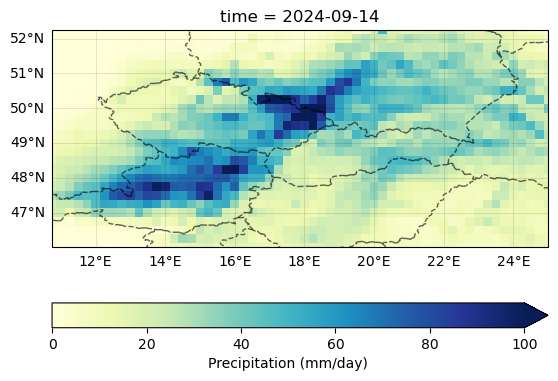

In [18]:
# select a single day of data to plot
ds_event = ds.sel(time = "2024-09-14")

fig = ds_event.plot(cmap = "YlGnBu",            # colour scheme to use for plotting
                    vmin = 0, vmax = 100,       # set min & max values for colour scale
                    subplot_kws = {"projection" : cartopy.crs.PlateCarree(),               # tell it which projection to use
                                   "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())    # only plot the area covered by the data
                                  },     
                    cbar_kwargs = {"location" : "bottom",                   # move the colourbar (scale bar) to the bottom
                                   "label" : "Precipitation (mm/day)"})     # relabel the colourbar


ax = fig.axes      # give a name to the figure axes so that we can add extra elements
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                  # add national borders
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])         # add gridlines
ax.coastlines(color = "k")                                                       # add coastlines

plt.savefig("example-plot.png", bbox_inches = "tight")

## Plot several days together

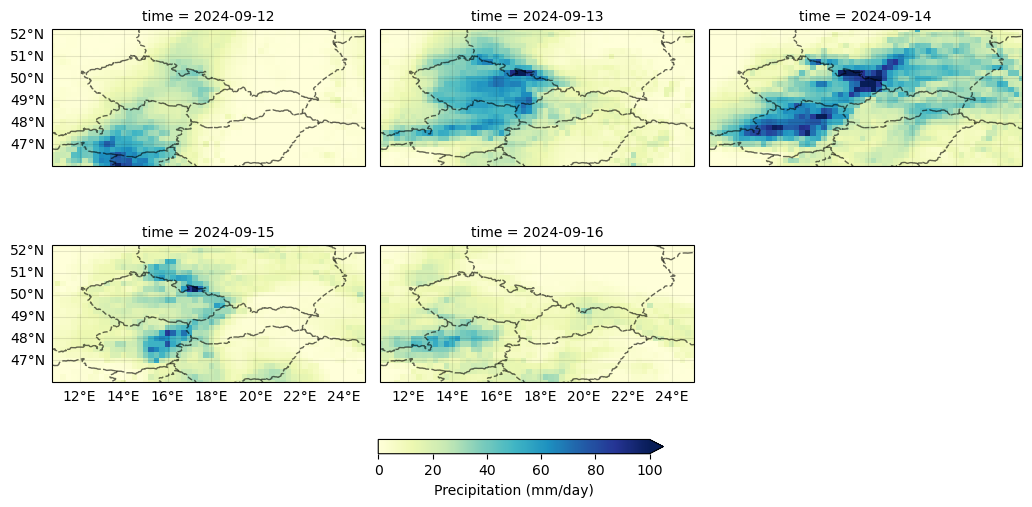

In [30]:
# select a range of dates to plot (not too many or the plots will be tiny!)
ds_event = ds.sel(time = slice("2024-09-12", "2024-09-16"))

# get the extent of the data (this will help to avoid messy plots when we add geographic features)
data_area = (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())

fig = ds_event.plot(col = "time",                                       # each panel should show a different time
                    col_wrap = 3,                                       # number of panels to show per row
                    cmap = "YlGnBu",                                    # colour scheme to use for plotting
                    vmin = 0, vmax = 100,                               # set min & max values for colour scale
                    # specify the projection for each panel
                    subplot_kws = {
                        "projection" : cartopy.crs.PlateCarree(),       # map projection so that we can add geographic features
                        "extent" : data_area                            # only plot the area covered by the data
                    },     
                    # specify how the colour bar should look
                    cbar_kwargs = {
                        "location" : "bottom",                          # move the colourbar (scale bar) to the bottom
                        "label" : "Precipitation (mm/day)",             # relabel the colourbar
                        "fraction" : 0.025,                             # how big the colourbar should be
                        "pad" : 0.1                                     # how much space between the colourbar and the panels
                    })            

# this time, we have to add the borders and gridlines to each panel individually
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                # add national borders
    ax.gridlines(color = "k", alpha = 0.1)                                         # add gridlines but don't draw the labels
    ax.coastlines(color = "k")                                                     # add coastlines
    
for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])            # y-labels on leftmost column
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])         # x-labels on the bottom row 

# Optional: manually set the title of each panel (make sure you make as many titles as there are panels!)
# titles = ["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"]
# for ax, title in zip(fig.axs.flat, titles):
#     ax.set_title(title)

## Add sites where impacts occurred

In [32]:
# make a list of the locations where impacts were reported 
# these could be a village, city, state, or country - just has to be a real place
# you may need to specify the country if more than one place exists with the same name, eg. "Vienna, Austria"
affected_sites = ["Vienna", "Graz", "Glucholazy", "Litovel", "Lower Austria"]

# use user-defined function to get the coordinates and turn into a table
px = pd.DataFrame([get_latlon(s) for s in affected_sites])

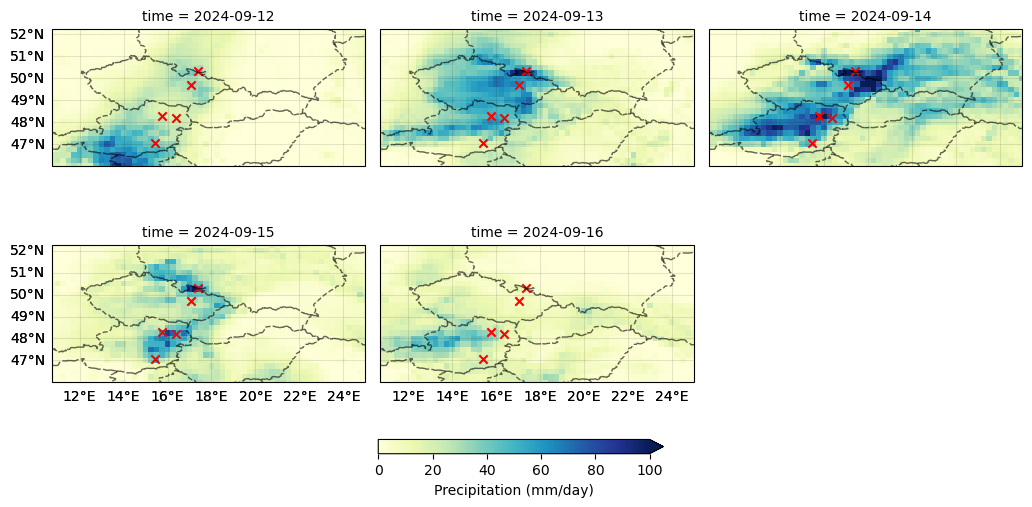

In [34]:
# replicate the plot that we made above
fig = ds_event.plot(col = "time",                                       # each panel should show a different time
                    col_wrap = 3,                                       # number of panels to show per row
                    cmap = "YlGnBu",                                    # colour scheme to use for plotting
                    vmin = 0, vmax = 100,                               # set min & max values for colour scale
                    # specify the projection for each panel
                    subplot_kws = {
                        "projection" : cartopy.crs.PlateCarree(),       # map projection so that we can add geographic features
                        "extent" : data_area                            # only plot the area covered by the data
                    },     
                    # specify how the colour bar should look
                    cbar_kwargs = {
                        "location" : "bottom",                          # move the colourbar (scale bar) to the bottom
                        "label" : "Precipitation (mm/day)",             # relabel the colourbar
                        "fraction" : 0.025,                             # how big the colourbar should be
                        "pad" : 0.1                                     # how much space between the colourbar and the panels
                    })            

# this time, we have to add the borders and gridlines to each panel individually
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                # add national borders
    ax.gridlines(color = "k", alpha = 0.1)                                         # add gridlines but don't draw the labels
    ax.coastlines(color = "k")                                                     # add coastlines
    ax.scatter(px.lon, px.lat, marker = "x", color = "red")                        # **NEW ELEMENT** add points where impacts were reported
    
for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])            # y-labels on leftmost column
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])         # x-labels on the bottom row 

# Optional: manually set the title of each panel (make sure you make as many titles as there are panels!)
# titles = ["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"]
# for ax, title in zip(fig.axs.flat, titles):
#     ax.set_title(title)

# Daily anomalies

## Calculate daily anomalies

In [ ]:
# select only the period that we want to compare (could be the whole year, could be just selected months)
ds_subset = ds.sel(time = ds.time.dt.month.isin([5,6,7,8,9]))

# calculate the mean daily rainfall during those months from 1990-2020 (standard climatology period)
ds_clim = ds_subset.sel(time = slice("1990", "2020")).mean("time")

# calculate the daily anomalies with respect to this climatology
ds_anom = ds_subset - ds_clim

## Plot daily anomalies

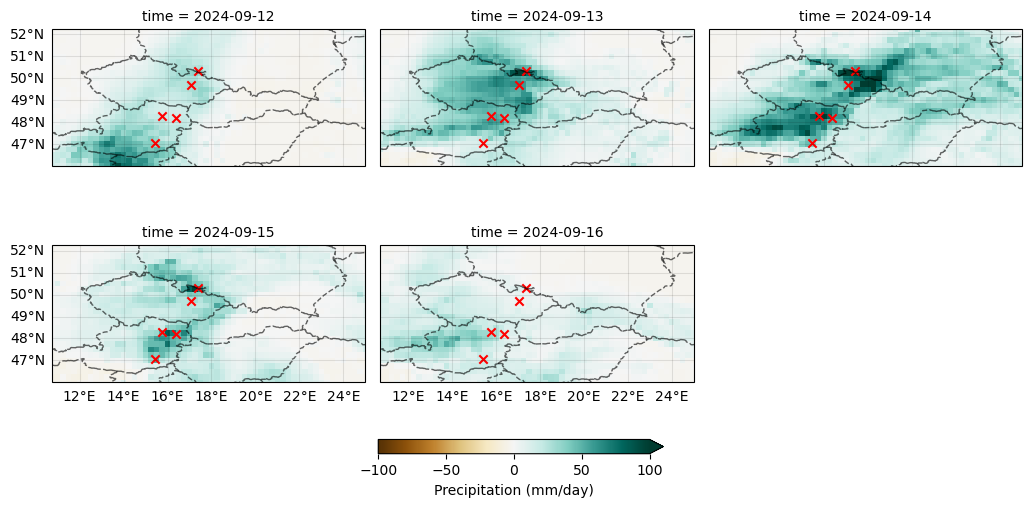

In [39]:
# select just the dates we're interested in plotting
ds_event_anom = ds_anom.sel(time = slice("2024-09-12", "2024-09-16"))

# replicate the plot that we made above, but this time we should use a DIVERGENT colour scheme and set the vmin and vmax to be symmetric about zero
fig = ds_event_anom.plot(col = "time",                                       # each panel should show a different time
                         col_wrap = 3,                                       # number of panels to show per row
                         cmap = "BrBG",                                    # colour scheme to use for plotting
                         vmin = -100, vmax = 100,                               # set min & max values for colour scale
                         # specify the projection for each panel
                         subplot_kws = {
                             "projection" : cartopy.crs.PlateCarree(),       # map projection so that we can add geographic features
                             "extent" : data_area                            # only plot the area covered by the data
                         },     
                         # specify how the colour bar should look
                         cbar_kwargs = {
                             "location" : "bottom",                          # move the colourbar (scale bar) to the bottom
                             "label" : "Precipitation (mm/day)",             # relabel the colourbar
                             "fraction" : 0.025,                             # how big the colourbar should be
                             "pad" : 0.1                                     # how much space between the colourbar and the panels
                         })     

# this time, we have to add the borders and gridlines to each panel individually
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)                # add national borders
    ax.gridlines(color = "k", alpha = 0.1)                                         # add gridlines but don't draw the labels
    ax.coastlines(color = "k")                                                     # add coastlines
    ax.scatter(px.lon, px.lat, marker = "x", color = "red")                        # **NEW ELEMENT** add points where impacts were reported
    
for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])            # y-labels on leftmost column
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])         # x-labels on the bottom row 

# Maps of accumulations (the 'event map')

In [63]:
# how many days to accumulate? (how long did the event last)
ndays = 4

# get the n-day rolling mean (could also use the sum for precipitation, if preferred)
ds_nday = ds.rolling(time = ndays, center = False).mean()

Text(0.5, 1.0, 'Average daily rainfall from September 13th-16th')

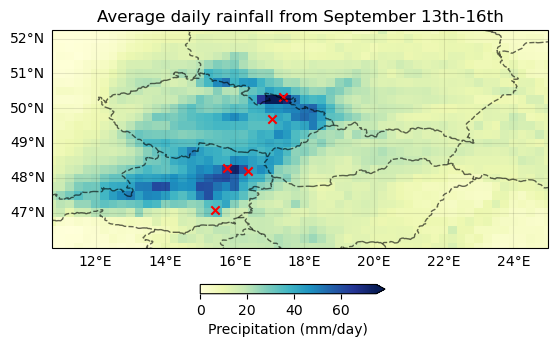

In [68]:
# select the date on which the event finished
nday_event = ds_nday.sel(time = "2024-09-16")

# plot the n-day event
fig = nday_event.plot(cmap = "YlGnBu",                                    # colour scheme to use for plotting
                      vmin = 0, vmax = 75,                               # set min & max values for colour scale
                      # specify the projection for each panel
                      subplot_kws = {
                          "projection" : cartopy.crs.PlateCarree(),       # map projection so that we can add geographic features
                          "extent" : data_area                            # only plot the area covered by the data
                      },     
                      # specify how the colour bar should look
                      cbar_kwargs = {
                          "location" : "bottom",                          # move the colourbar (scale bar) to the bottom
                          "label" : "Precipitation (mm/day)",             # relabel the colourbar
                          "fraction" : 0.025,                             # how big the colourbar should be
                          "pad" : 0.1                                     # how much space between the colourbar and the panels
                      })            

ax = fig.axes
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)            # add national borders
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])   # add gridlines
ax.coastlines(color = "k")                                                 # add coastlines
ax.scatter(px.lon, px.lat, marker = "x", color = "red")                    # add points where impacts were reported

# give this panel a better title
ax.set_title("Average daily rainfall from September 13th-16th")

# Averaging over an area

## Square/rectangular area


If you're looking at a region with both land and sea, remember to mask out the land first (see below)

In [71]:
# set the region we want to draw a box around
xn,xx,yn,yx = [14,18,47,51]

Text(0.5, 1.0, 'Average daily rainfall from September 13th-16th')

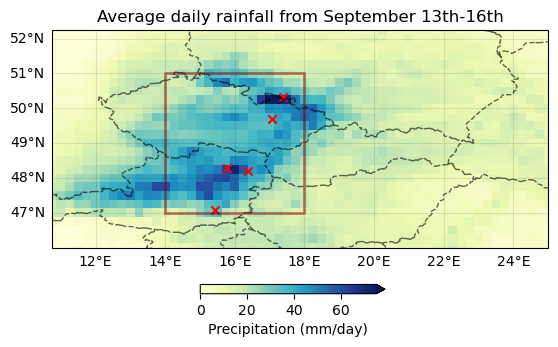

In [73]:
# check the region by adding it to the plot
fig = nday_event.plot(cmap = "YlGnBu",                                    # colour scheme to use for plotting
                      vmin = 0, vmax = 75,                               # set min & max values for colour scale
                      # specify the projection for each panel
                      subplot_kws = {
                          "projection" : cartopy.crs.PlateCarree(),       # map projection so that we can add geographic features
                          "extent" : data_area                            # only plot the area covered by the data
                      },     
                      # specify how the colour bar should look
                      cbar_kwargs = {
                          "location" : "bottom",                          # move the colourbar (scale bar) to the bottom
                          "label" : "Precipitation (mm/day)",             # relabel the colourbar
                          "fraction" : 0.025,                             # how big the colourbar should be
                          "pad" : 0.1                                     # how much space between the colourbar and the panels
                      })            

ax = fig.axes
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)            # add national borders
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])   # add gridlines
ax.coastlines(color = "k")                                                 # add coastlines
ax.scatter(px.lon, px.lat, marker = "x", color = "red")                    # add points where impacts were reported

# draw the box on the map
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

# give this panel a better title
ax.set_title("Average daily rainfall from September 13th-16th")

In [81]:
# extract the data over this smaller region only
ds_box = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx))

# compute spatial average
ts_box = ds_box.mean(["lat", "lon"])

# save the data we've extracted
ts_box.to_netcdf("timeseries_pr-box.nc")

## Pre-loaded regions

The `regionmask` package provides predefined shapefiles for countries, US states and coastlines  
To use a different regionmask, replace `countries_50` with `us_states_50` or `land_50`

If you're looking at a region with both land and sea, remember to mask out the land first

In [107]:
# load the regionmask so that we can manipulate it
sf = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe()

# we'll need to filter the shapefile to idenfity the region(s) of interest
# look at the shapefile to see which column we should filter on
sf

,abbrevs,names,geometry
numbers,,,
0,ZW,Zimbabwe,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,ZM,Zambia,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,YE,Yemen,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,VN,Vietnam,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,VE,Venezuela,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."
...,...,...,...
237,AF,Afghanistan,"POLYGON ((66.52227 37.34849, 66.82773 37.37129..."
238,SG,Siachen Glacier,"POLYGON ((77.04863 35.10991, 77.00449 35.19634..."
239,AQ,Antarctica,"MULTIPOLYGON (((-45.71777 -60.5209, -45.49971 ..."


<Axes: >

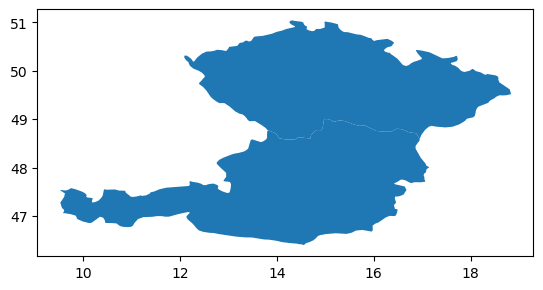

In [112]:
# then we can select a single country, or a list of countries
sf_subset = sf.loc[sf.names.isin(["Austria", "Czechia"])]
sf_subset.plot()

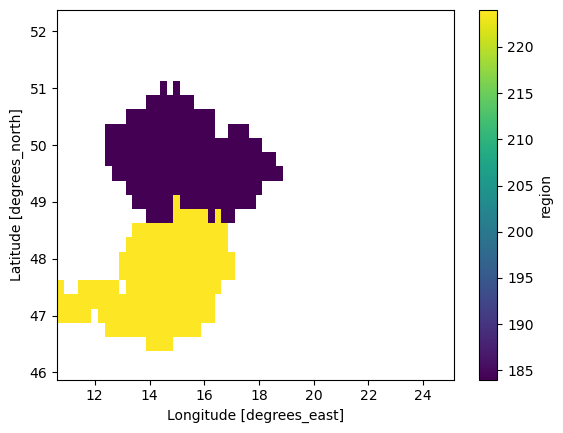

In [116]:
# we can use this to create a regionmask for the dataset `ds` by selecting only points that lie within the selected region
rm = regionmask.mask_geopandas(sf_subset, ds.lon, ds.lat)

# coloured points will be included in the selected area
rm.plot()

In [118]:
# Finally, we can select just the region(s) we're interested in, and average over that
ts_countries = ds.where(~np.isnan(rm)).mean(["lat", "lon"])

# save the data we've extracted
ts_countries.to_netcdf("timeseries_pr-countries.nc")